<a href="https://colab.research.google.com/github/kazutoki-m/rent_prediction/blob/main/WestCoast_KM_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
##  Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in the dataset and explore

In [51]:
df = pd.read_csv('/content/drive/MyDrive/data/cleaned-datasets/west_coast.csv')
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,True,True,False,False,False,False,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,False,False,False,False,False,False,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca
2,7043634882,https://reno.craigslist.org/apa/d/sparks-state...,reno / tahoe,https://reno.craigslist.org,1813,apartment,1683,2,2.0,True,True,True,False,False,False,w/d in unit,attached garage,https://images.craigslist.org/00t0t_erYqC6LgB8...,2BD | 2BA | 1683SQFTDiscover exceptional servi...,39.6269,-119.708,ca
3,7049045324,https://reno.craigslist.org/apa/d/reno-1x1-fir...,reno / tahoe,https://reno.craigslist.org,1095,apartment,708,1,1.0,True,True,True,False,False,False,w/d in unit,carport,https://images.craigslist.org/00303_3HSJz75zlI...,MOVE IN SPECIAL FREE WASHER/DRYER WITH 6 OR 12...,39.4477,-119.771,ca
4,7049043759,https://reno.craigslist.org/apa/d/reno-no-long...,reno / tahoe,https://reno.craigslist.org,289,apartment,250,0,1.0,True,True,True,True,False,True,laundry on site,NaN,https://images.craigslist.org/01616_fALAWFV8zQ...,"Move In Today: Reno Low-Cost, Clean & Furnishe...",39.5357,-119.805,ca


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69276 entries, 0 to 69275
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       69276 non-null  int64  
 1   url                      69276 non-null  object 
 2   region                   69276 non-null  object 
 3   region_url               69276 non-null  object 
 4   price                    69276 non-null  int64  
 5   type                     69276 non-null  object 
 6   sqfeet                   69276 non-null  int64  
 7   beds                     69276 non-null  int64  
 8   baths                    69276 non-null  float64
 9   cats_allowed             69276 non-null  bool   
 10  dogs_allowed             69276 non-null  bool   
 11  smoking_allowed          69276 non-null  bool   
 12  wheelchair_access        69276 non-null  bool   
 13  electric_vehicle_charge  69276 non-null  bool   
 14  comes_furnished       

In [53]:
df.describe()

,id,price,sqfeet,beds,baths,lat,long
count,6.927600e+04,69276.000000,69276.000000,69276.000000,69276.000000,69276.000000,69276.000000
mean,7.042683e+09,1455.010639,1002.321237,1.935692,1.526611,39.419792,-119.223778
std,8.584018e+06,666.346128,445.766431,0.892687,0.602936,6.767586,8.932213
min,7.004032e+09,110.000000,150.000000,0.000000,0.000000,19.100200,-159.530000
25%,7.037851e+09,1019.000000,743.000000,1.000000,1.000000,34.249100,-121.481000
50%,7.045849e+09,1320.000000,930.000000,2.000000,1.000000,38.002400,-119.065000
75%,7.049334e+09,1705.000000,1125.000000,2.000000,2.000000,44.561600,-115.127500
max,7.051291e+09,9910.000000,9600.000000,8.000000,6.500000,64.993700,-70.488300


In [54]:
sub2 = df.copy()

In [55]:
sub2.isnull().mean()

id                         0.000000
url                        0.000000
region                     0.000000
region_url                 0.000000
price                      0.000000
type                       0.000000
sqfeet                     0.000000
beds                       0.000000
baths                      0.000000
cats_allowed               0.000000
dogs_allowed               0.000000
smoking_allowed            0.000000
wheelchair_access          0.000000
electric_vehicle_charge    0.000000
comes_furnished            0.000000
laundry_options            0.143787
parking_options            0.253551
image_url                  0.000000
description                0.000000
lat                        0.000000
long                       0.000000
state                      0.000000
dtype: float64

In [56]:
sub2.shape

(69276, 22)

## Data Cleaning#
1. Winsorize rows with more than three standard deviations by price and sqfeet
2. Log transformed price and sqfeet columns as they seem log-normal
3. Create a column 'pets_allowed' where either cats or dogs are allowed to have
4. Drop 'type' of assisted living as this seems an outlier
5. Create a parking_dummy where I assign 1 to options with (medians price > 1500), and 0 to the others. I filled missing values with 0 as they seem similar in distribution.
6 Ceate a laundry_dummy where I got three categories; in-unit, in_building, and no_laundry. The missing values are imputed to in_building as they seem similar in distribution.
7. Use state variable as categorical dummy variable  

# Data Cleaning: Winsorize outside Three Standard Deviations

In [57]:
from scipy import stats
sub2 = sub2[(np.abs(stats.zscore(sub2[['price','sqfeet']])) < 3).all(axis=1)]
sub2.describe()

,id,price,sqfeet,beds,baths,lat,long
count,6.733000e+04,67330.000000,67330.000000,67330.000000,67330.000000,67330.000000,67330.000000
mean,7.042716e+09,1400.388697,957.131635,1.888965,1.494980,39.473388,-119.172299
std,8.567542e+06,539.956559,325.938948,0.843428,0.566676,6.756384,8.879616
min,7.004032e+09,110.000000,150.000000,0.000000,0.000000,19.100200,-159.530000
25%,7.037885e+09,1010.000000,738.000000,1.000000,1.000000,34.269600,-121.478000
50%,7.045878e+09,1300.000000,918.000000,2.000000,1.000000,38.008700,-119.064000
75%,7.049337e+09,1680.000000,1100.000000,2.000000,2.000000,44.588775,-115.091250
max,7.051291e+09,3450.000000,2338.000000,8.000000,6.000000,64.993700,-70.488300


# Data Cleaning: Log Transformation

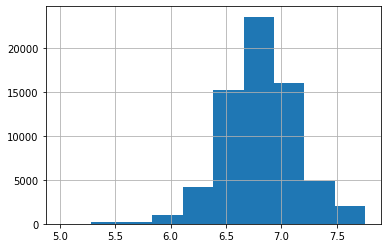

In [58]:
np.log(sub2['sqfeet']).hist()

In [59]:
sub2['sqfeet_log'] = np.log(sub2['sqfeet'])

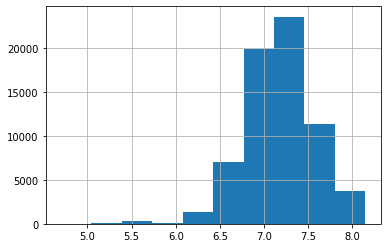

In [60]:
np.log(sub2['price']).hist()

In [61]:
sub2['price_log'] = np.log(sub2['price'])

# Data Clearning: Pets Allowed

In [86]:
## Create a new column called 'pets_allowed' where either cats or dogs are allowed meaning pets in general allowed. 
temp = sub2[['cats_allowed', 'dogs_allowed']].apply(sum, axis=1)
pets_allowed = []
for t in temp:
  if t == 0:
    pets_allowed.append(0)
  else:
    pets_allowed.append(1)
sub2['pets_allowed'] = pets_allowed

# Data Cleaning: Type

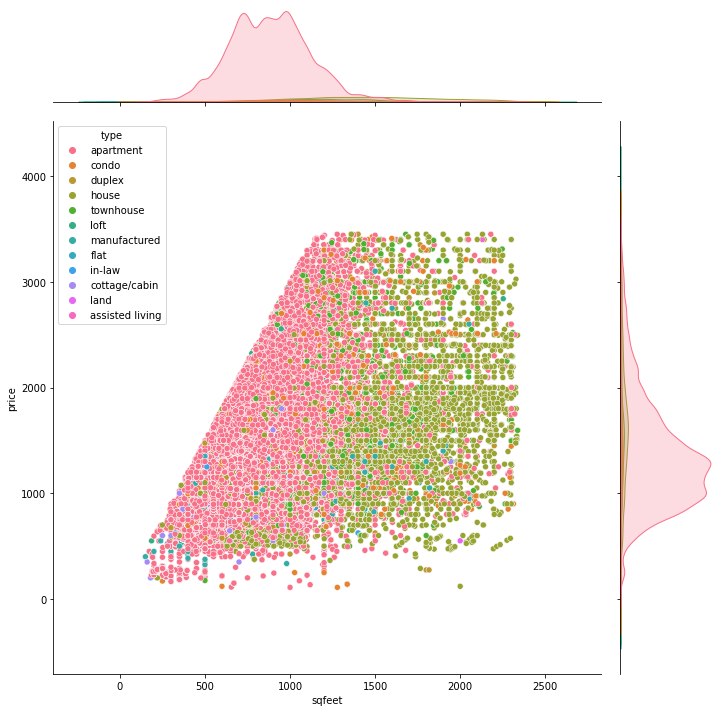

In [63]:
sns.jointplot(data=sub2, x="sqfeet", y="price", hue='type', height=10)

<Figure size 432x288 with 0 Axes>

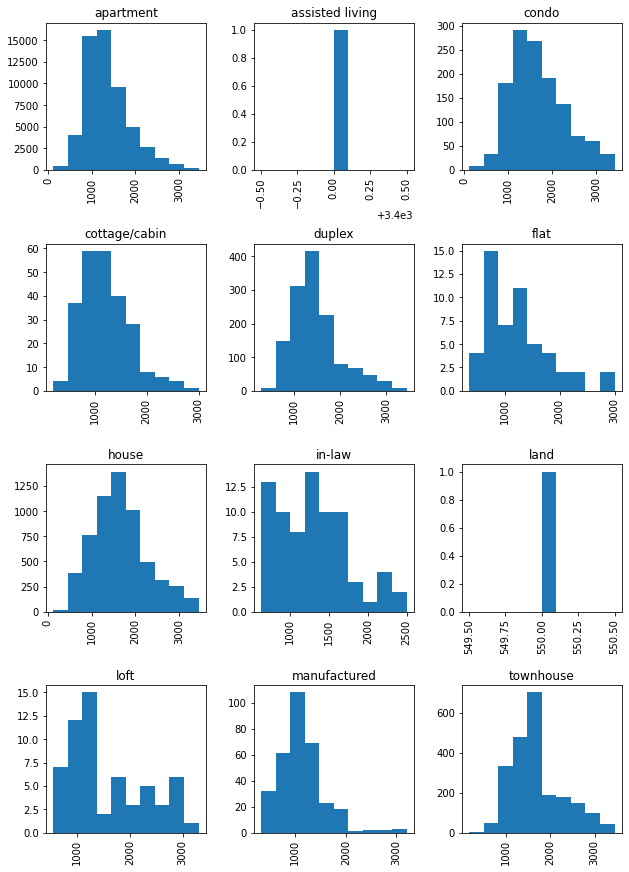

In [64]:
plt.figure()
sub2['price'].hist(by=sub2['type'],figsize=(10,15))
plt.show()

In [65]:
## Drop category of "Assisted Living" as this seems to be an outlier
sub2 = sub2[sub2['type'] !='assisted living']

In [66]:
sub2['type'].value_counts()

apartment        55805
house             5920
townhouse         2227
duplex            1344
condo             1280
manufactured       319
cottage/cabin      246
in-law              75
loft                60
flat                52
land                 1
Name: type, dtype: int64

In [67]:
sub2.groupby('type').mean()['price'].sort_values(ascending=False)

type
townhouse        1686.989672
condo            1677.432812
house            1656.050169
loft             1581.150000
duplex           1466.869792
apartment        1356.519488
in-law           1287.053333
flat             1248.903846
cottage/cabin    1188.784553
manufactured     1114.542320
land              550.000000
Name: price, dtype: float64

# Feature Engineering Parking Options

In [68]:
sub2['parking_options'].unique()

array(['carport', 'attached garage', nan, 'off-street parking',
       'detached garage', 'street parking', 'no parking', 'valet parking'],
      dtype=object)

In [69]:
print('The average price of the whole rents is: ', sub2['price'].median())
print('The average price of rents with null parking options is: ',sub2[sub2['parking_options'].isnull()]['price'].median())

The average price of the whole rents is:  1300.0
The average price of rents with null parking options is:  1275.0


In [70]:
sub2.groupby('parking_options').median()['price'].sort_values(ascending=False)

parking_options
attached garage       1650.0
detached garage       1620.0
valet parking         1512.0
carport               1280.0
no parking            1190.0
street parking        1179.0
off-street parking    1125.0
Name: price, dtype: float64

In [71]:
sub2['parking_options'].value_counts()

carport               23047
off-street parking    12489
attached garage        9301
detached garage        3352
street parking         1534
no parking              364
valet parking            30
Name: parking_options, dtype: int64

In [72]:
temp = (sub2.groupby('parking_options').median()['price'] > 1500).reset_index()
park_ones =  list(temp[temp['price']==True]['parking_options'])

park_dummy = []
for park in sub2['parking_options']:
  if park in park_ones:
    park_dummy.append(1)
  else:
    park_dummy.append(0)
sub2['park_dummy'] = park_dummy

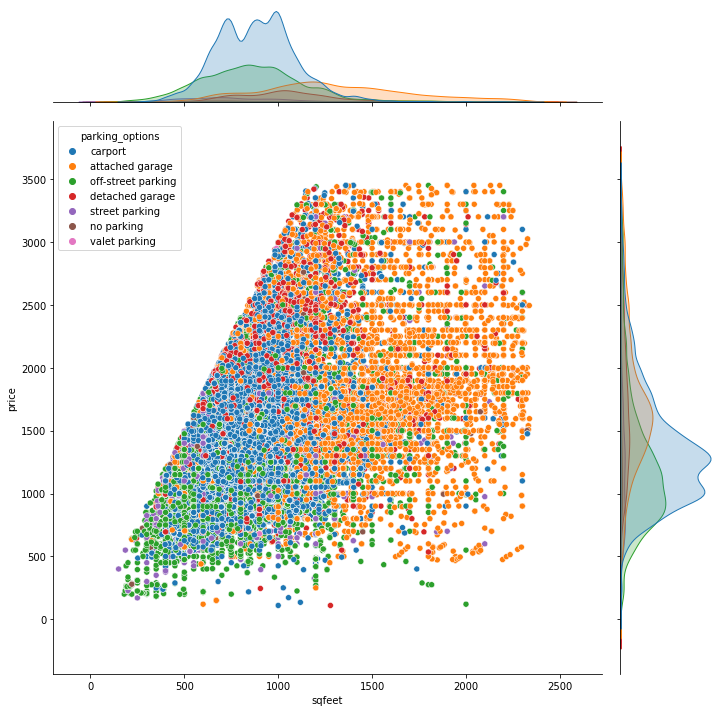

In [73]:
sns.jointplot(data=sub2, x="sqfeet", y="price", hue='parking_options', height=10)

<Figure size 432x288 with 0 Axes>

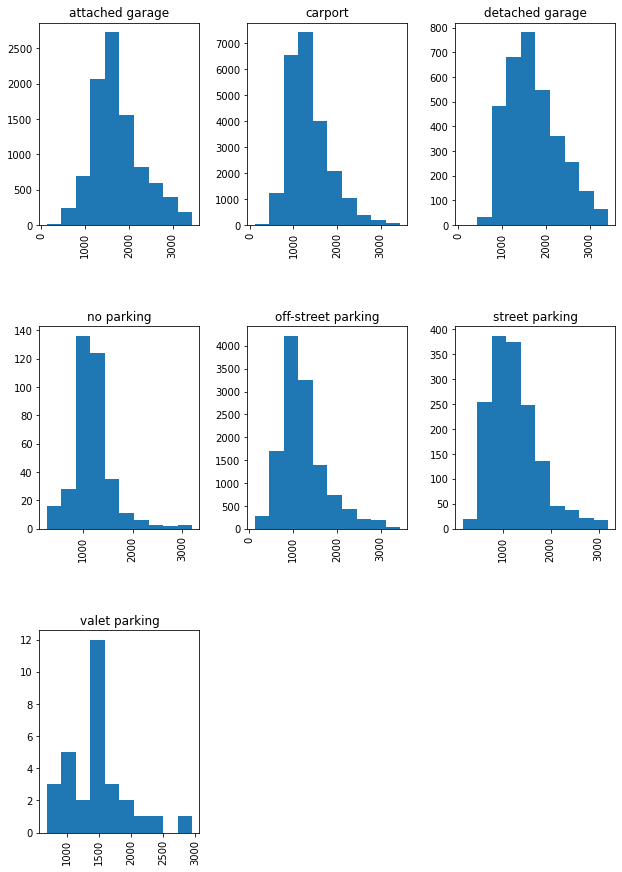

In [74]:
plt.figure()
sub2['price'].hist(by=sub2['parking_options'],figsize=(10,15))
plt.show()

# Feature Engineering: Laundry Options

In [75]:
sub2['laundry_options'].value_counts()

w/d in unit           31242
laundry on site       14277
w/d hookups            8150
laundry in bldg        3497
no laundry on site      514
Name: laundry_options, dtype: int64

In [76]:
sub2.groupby('laundry_options').mean()['price'].sort_values(ascending=False)

laundry_options
w/d in unit           1525.839031
w/d hookups           1381.478405
laundry in bldg       1272.610237
laundry on site       1196.563073
no laundry on site     984.252918
Name: price, dtype: float64

The number of missing value is:  9649
The average price of missing value is:  1380.0294331018758


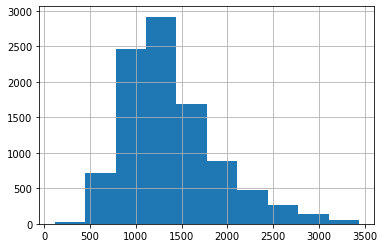

In [77]:
## Check the price values of NaN Laundry Options
print('The number of missing value is: ', sub2['laundry_options'].isnull().sum())
print('The average price of missing value is: ',sub2[sub2['laundry_options'].isnull()]['price'].mean())
sub2[sub2['laundry_options'].isnull()]['price'].hist()

<Figure size 432x288 with 0 Axes>

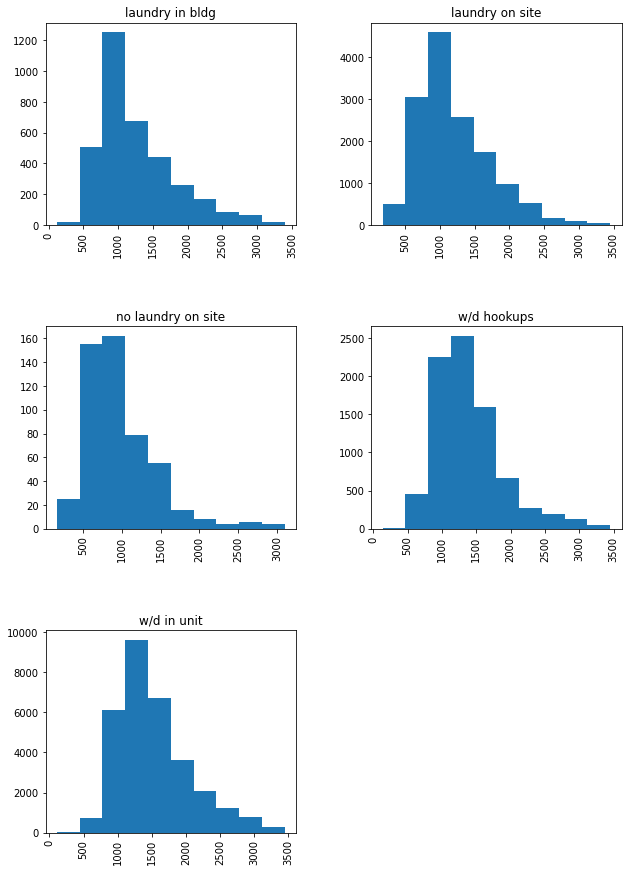

In [78]:
plt.figure()
sub2['price'].hist(by=sub2['laundry_options'],figsize=(10,15))
plt.show()

In [79]:
## It seems in_unit laundry implies a higher rent price
in_unit = ['w/d in unit']
in_building = ['laundry on site','w/d hookups','laundry in bldg']
no_laundry = ['no laundry on site']

## I will treat the missing values as in_building as the mean and median seems to be similar
laundry_dummy = []
for laundry in sub2['laundry_options']:
  if laundry in in_unit:
    laundry_dummy.append('in_unit')
  elif laundry in no_laundry:
    laundry_dummy.append('no_laundry')
  else:
    laundry_dummy.append('in_building')
sub2['laundry_dummy'] = laundry_dummy

# Feature Engineering: State and Region

In [80]:
sub2['state'].value_counts()

ca    27328
or     7735
az     6530
wa     6216
ut     5066
id     4238
nv     2742
nm     2714
ak     2092
mt     1247
hi     1243
wy      178
Name: state, dtype: int64

In [81]:
## It looks make sense to include 'state' as categorical variable
sub2.groupby('state').mean()['price'].sort_values(ascending=False)

state
hi    1978.167337
ca    1673.521626
wa    1396.862773
or    1314.571687
ut    1207.946309
ak    1159.070746
nv    1127.564187
mt    1123.312751
id    1115.288108
az    1039.589433
wy     953.623596
nm     928.209285
Name: price, dtype: float64

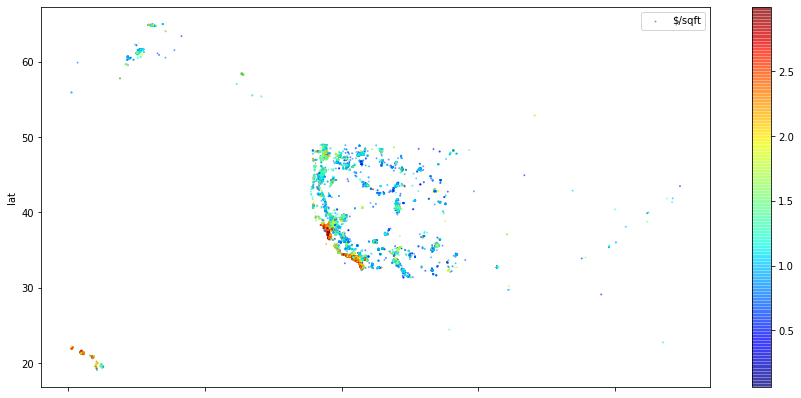

In [82]:
sub2.plot(kind='scatter', x='long', y='lat', alpha=0.5,
         s=1, label='$/sqft',  
         c=sub2['price']/sub2['sqfeet'],   #  set symbol color on house value 
         cmap=plt.get_cmap('jet'),      
         colorbar=True,
         figsize=(15,7))
plt.legend()

# Check Correlations across Columns

In [83]:
corr_matrix = sub2.corr()
corr_matrix["price"].sort_values(ascending=False)

price                      1.000000
price_log                  0.956823
sqfeet_log                 0.469214
sqfeet                     0.447847
baths                      0.349803
park_dummy                 0.293850
beds                       0.279365
electric_vehicle_charge    0.119832
id                         0.096672
wheelchair_access          0.014514
dogs_allowed               0.007912
pet_allowed                0.006408
cats_allowed              -0.001992
comes_furnished           -0.050941
smoking_allowed           -0.072170
long                      -0.194417
lat                       -0.209130
Name: price, dtype: float64

In [88]:
## Preprocess Boolean variables to one-hot
bool_cols = ['smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished','comes_furnished']
bool_vars = sub2[bool_cols]
sub2[bool_cols] = sub2[bool_cols].astype(int)

sub2_processed = sub2.copy()[['price','price_log','type','pets_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished','comes_furnished','laundry_dummy','park_dummy','sqfeet','sqfeet_log','beds','baths','lat','long','state']]

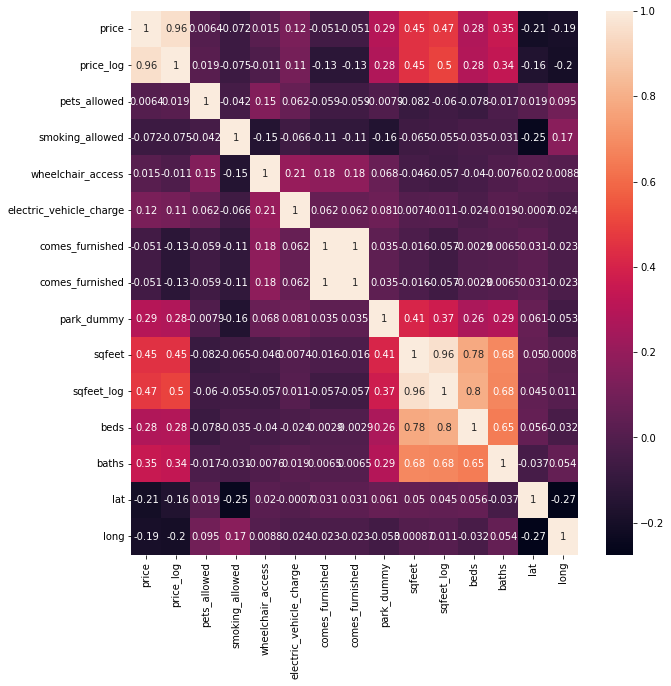

In [89]:
fig, ax = plt.subplots(figsize=(12,12))         
sns.heatmap(sub2_processed.corr(),annot=True, ax=ax)

# Split and Preprocess the Dataset

In [90]:
# I did not include several columns such as 'id','url', 'region','image_url','description','state' for now.
# y = sub2_processed['price']
y = sub2_processed['price']
X = sub2_processed.drop(columns=['price'])

X.shape,y.shape

((67329, 17), (67329,))

In [91]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_raw.shape, y_train.shape

In [93]:
cat_cols = ['type','laundry_dummy','state']
con_cols = ['sqfeet_log','beds','baths']


In [94]:
from sklearn.preprocessing import StandardScaler
preprocessor_dummy = ColumnTransformer(transformers=[('cat', OneHotEncoder(categories='auto', drop='first'), cat_cols),
                                                   ('cont', StandardScaler(), con_cols)])

In [95]:
X_train_dummy = preprocessor_dummy.fit_transform(X_train_raw)
X_test_dummy = preprocessor_dummy.transform(X_test_raw)

# Building a model

## Simple Linear Regression

In [96]:
from sklearn import linear_model
from sklearn.metrics import r2_score
lin_reg = linear_model.LinearRegression(n_jobs=1)
model = lin_reg.fit(X_train_dummy, y_train)

y_test_pred = lin_reg.predict(X_test_dummy)
y_train_pred = lin_reg.predict(X_train_dummy)

print('The R2 score is: ',model.score(X_test_dummy, y_test))

from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test, y_test_pred) 
lin_rmse = np.sqrt(lin_mse) 
print('The RMSE is: ', lin_rmse)

The R2 score is:  0.49873595792074044
The RMSE is:  383.10509858593554


### Ridge Regression

In [97]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

alphas = np.logspace(-3, 1.5, num = 30)

model = RidgeCV(alphas = alphas,fit_intercept = True, normalize = False)
model.fit(X_train_dummy, y_train)
# model = ridge_reg.fit(X_train, y_train)
y_test_pred = model.predict(X_test_dummy)
y_train_pred = model.predict(X_train_dummy)

print('The best alpha is: ', model.alpha_)
print('The R2 score is: ',model.score(X_test_dummy, y_test))

lin_mse = mean_squared_error(y_test, y_test_pred) 
lin_rmse = np.sqrt(lin_mse) 
print('The RMSE is: ',lin_rmse)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


The best alpha is:  7.5737391758950094
The R2 score is:  0.4987321743544664
The RMSE is:  383.10654443151145


## Preprocessing: ColumnTransformation {'cat', OneHotEncoder, 'con', StandardScaler}

In [98]:
preprocessor_ohe = ColumnTransformer(transformers=[('cat', OneHotEncoder(categories='auto'), cat_cols),
                                                   ('cont', StandardScaler(), con_cols)])

In [99]:
X_train_ohe = preprocessor_ohe.fit_transform(X_train_raw)
X_test_ohe = preprocessor_ohe.transform(X_test_raw)

### K-Nearest-Neigbor Regression

In [100]:
from sklearn import neighbors

knn_reg = neighbors.KNeighborsRegressor(n_neighbors=20,
                                        weights='uniform',  # ‘distance’ weights points by inverse of their distance
                                        algorithm='auto',  # out of ‘ball_tree’, ‘kd_tree’, ‘brute’
                                        leaf_size=30)  # for tree algorithms

model = knn_reg.fit(X_train_ohe, y_train)
y_test_pred = model.predict(X_test_ohe)
y_train_pred = model.predict(X_train_ohe)

knn_mse = mean_squared_error(y_test, y_test_pred) 
knn_rmse = np.sqrt(knn_mse) 
print('The RMSE is: ',knn_rmse)

print('The R2 score is: ',model.score(X_test_ohe, y_test))

The RMSE is:  331.7674260152755
The R2 score is:  0.624077625843412


## Decision Tree Regression

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
model = tree_reg.fit(X_train_ohe, y_train)

y_test_pred = model.predict(X_test_ohe)
y_train_pred = model.predict(X_train_ohe)

tree_mse = mean_squared_error(y_test, y_test_pred) 
tree_rmse = np.sqrt(tree_mse) 
print('The RMSE is: ',tree_rmse)
print('The Accuracy score is: ', model.score(X_test_ohe, y_test))

The RMSE is:  336.73645310556606
The Accuracy score is:  0.6127325870765991


## Random Forest Regression

In [102]:
from sklearn import ensemble

rf_reg = ensemble.RandomForestRegressor(n_estimators=10,  # number of trees
                                        criterion='mse',  # how to measure fit
                                        max_depth=None,  # how deep tree nodes can go
                                        min_samples_split=2,  # samples needed to split node
                                        min_samples_leaf=1,  # samples needed for a leaf
                                        min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                        max_features='auto',  # max feats
                                        max_leaf_nodes=None,  # max nodes
                                        n_jobs=1, # how many to run parallel
                                        random_state=42)

model = rf_reg.fit(X_train_ohe, y_train.ravel())
y_test_pred = model.predict(X_test_ohe)
y_train_pred = model.predict(X_train_ohe)

rf_mse = mean_squared_error(y_test, y_test_pred) 
rf_rmse = np.sqrt(rf_mse) 
print('The RMSE is: ',rf_rmse)

# Accuracy score
print('The R2 score is: ', model.score(X_test_ohe, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:392: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE is:  306.6931986560286
The R2 score is:  0.6787530758369116


## Fine tune the hyperparameters on Random Forest

In [103]:
# Credit: https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10,20,30], 'max_features': [2,4,6,8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
rf_reg = ensemble.RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_ohe, y_train.ravel())
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [104]:
final_model = grid_search.best_estimator_

y_test_pred = final_model.predict(X_test_ohe)
y_train_pred = final_model.predict(X_train_ohe)

rf_mse = mean_squared_error(y_test, y_test_pred) 
rf_rmse = np.sqrt(rf_mse) 
print('The RMSE is: ',rf_rmse)

# Accuracy score
print('The R2 score is: ', final_model.score(X_test_ohe, y_test))

The RMSE is:  303.49062241627524
The R2 score is:  0.6854271473150868


In [109]:
param_grid = {
    'bootstrap': [True],
    'max_features': [4,6,8,16,32],
    'n_estimators': [30,40,50,100]
}

rf_reg = ensemble.RandomForestRegressor(random_state=42)

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train_ohe, y_train.ravel())
grid_search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

{'bootstrap': True, 'max_features': 16, 'n_estimators': 100}

In [110]:
final_model = grid_search.best_estimator_

y_test_pred = final_model.predict(X_test_ohe)
y_train_pred = final_model.predict(X_train_ohe)

rf_mse = mean_squared_error(y_test, y_test_pred) 
rf_rmse = np.sqrt(rf_mse) 
print('The RMSE is: ',rf_rmse)

# Accuracy score
print('The R2 score is: ', final_model.score(X_test_ohe, y_test))

The RMSE is:  300.59046860230967
The R2 score is:  0.6914105324989567
